Lets start by picking a couple of places we want to look at, all we need is the coordinates

In [ ]:
interesting_climate_sites = {
    "Barrow, Alaska (Utqiaġvik)": (71.2906, -156.7886),  # Arctic warming, permafrost melt
    "Greenland Ice Sheet": (72.0000, -40.0000),           # Glacial melt, sea level rise
    "Amazon Rainforest (Manaus)": (-3.1190, -60.0217),    # Carbon sink, deforestation impact
    "Sahara Desert (Tamanrasset, Algeria)": (22.7850, 5.5228),  # Heat extremes, desertification
    "Sahel (Niamey, Niger)": (13.5128, 2.1127),            # Precipitation shifts, droughts
    "Sydney, Australia": (-33.8688, 151.2093),             # Heatwaves, bushfires, El Niño sensitivity
    "Mumbai, India": (19.0760, 72.8777),                   # Monsoon variability, coastal flooding
    "Bangkok, Thailand": (13.7563, 100.5018),              # Sea-level rise, heat + humidity
    "Svalbard, Norway": (78.2232, 15.6469),                # Fastest Arctic warming
    "McMurdo Station, Antarctica": (-77.8419, 166.6863),   # Ice loss, ozone hole proximity
    "Cape Town, South Africa": (-33.9249, 18.4241),        # Water scarcity, shifting rainfall
    "Mexico City, Mexico": (19.4326, -99.1332),            # Air pollution, altitude-driven weather
    "Reykjavík, Iceland": (64.1355, -21.8954),             # Glacial melt, geothermal dynamics
}

In [ ]:
community_params = {
    "AG": ["T2M","T2M_MAX","T2M_MIN","WS2M","ALLSKY_SFC_SW_DWN","ALLSKY_SFC_LW_DWN",
           "CLRSKY_SFC_SW_DWN","T2MDEW","T2MWET","PS","RAIN","TS","RH2M","QV2M","CLOUD_AMT"],
    "RE": ["WD2M","WD50M","WS50M"],
    "SB": ["IMERG_PRECTOT"]
}

In [ ]:
# 3) Define date range (daily) in YYYYMMDD
start_date = "19810101"
end_date   = "20241231"


In [ ]:
import requests
import pandas as pd

def get_nasa_power_data(lat, lon, parameters, community, start, end):
    """
    Fetch daily data from NASA POWER API for given parameters and location.
    Dates must be in YYYYMMDD format (e.g., "20100101", "20201231").
    """
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": ",".join(parameters),
        "community": community,
        "latitude": lat,
        "longitude": lon,
        "start": start,
        "end": end,
        "format": "JSON"
    }
    response = requests.get(url, params=params)
    data = response.json()

    if "properties" not in data:
        print(f"❌ Error fetching {community} data for lat={lat}, lon={lon}: {data}")
        return pd.DataFrame()

    # Build one DataFrame per parameter, then combine
    param_data = data["properties"]["parameter"]
    dfs = [
        pd.DataFrame.from_dict(values, orient="index", columns=[param])
        for param, values in param_data.items()
    ]
    df_combined = pd.concat(dfs, axis=1)
    df_combined.index.name = "Date"
    return df_combined.sort_index().astype(float)

In [ ]:
# 4) Loop and collect
all_data = {}
for city, (lat, lon) in interesting_climate_sites.items():
    print(f"Fetching daily data for {city}...")
    city_data = {}
    for community, params in community_params.items():
        df = get_nasa_power_data(lat, lon, params, community, start_date, end_date)
        city_data[community] = df
    all_data[city] = city_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 1) For each city, join its communities on the date index
city_dfs = {
    city: comms["AG"]
                .join(comms["RE"], how="outer")
                .join(comms["SB"], how="outer")
    for city, comms in all_data.items()
}

# 2) Concatenate into one MultiIndexed DF: index = (City, Date)
combined_df = pd.concat(city_dfs, names=["City", "Date"])

# 3) Reset the index so City and Date become columns
combined_df = combined_df.reset_index()

# 4) Bring latitude/longitude in as columns
coords = pd.DataFrame.from_dict(
    interesting_climate_sites, orient="index", columns=["Latitude", "Longitude"]
).reset_index().rename(columns={"index": "City"})

combined_df = combined_df.merge(coords, on="City", how="left")

# then save into your Drive folder
combined_df.to_csv('/content/drive/MyDrive/climate_data.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd




Mounted at /content/drive


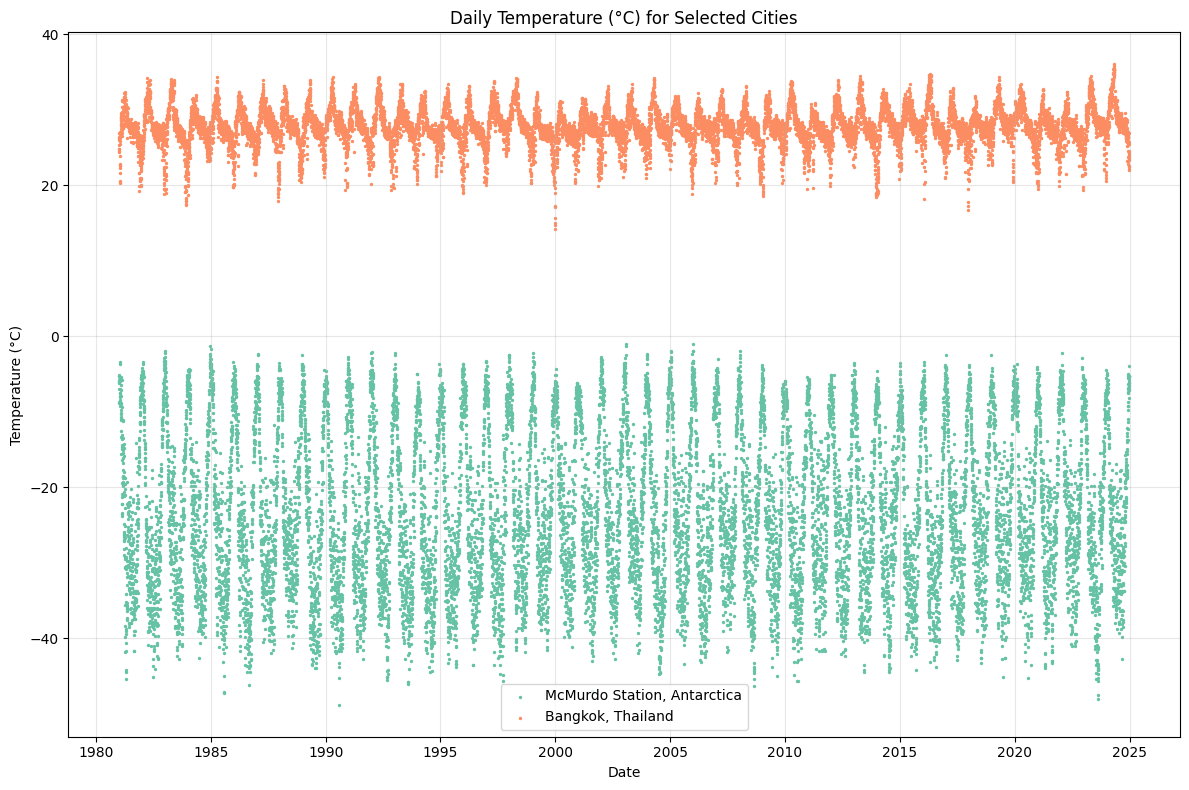

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn

# Load data
climate_df = pd.read_csv('/content/drive/MyDrive/TDS/Climate/climate_data.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'].astype(str), format='%Y%m%d')

# Filter for the specified cities
selected_cities = [
    'McMurdo Station, Antarctica',
    'Bangkok, Thailand',
]
df_selected_cities = climate_df[climate_df['City'].isin(selected_cities)].copy()

# Create a scatter plot with different colors for each city
plt.figure(figsize=(12, 8))

# Use a colormap for more aesthetic colors
colors = sns.color_palette("Set2", len(selected_cities)) # Using a seaborn color palette

for i, city in enumerate(selected_cities):
    df_city = df_selected_cities[df_selected_cities['City'] == city]
    plt.scatter(df_city['Date'], df_city['T2M'], label=city, s=2, color=colors[i]) # Using T2M for temperature and smaller dots

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Temperature (°C) for Selected Cities')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

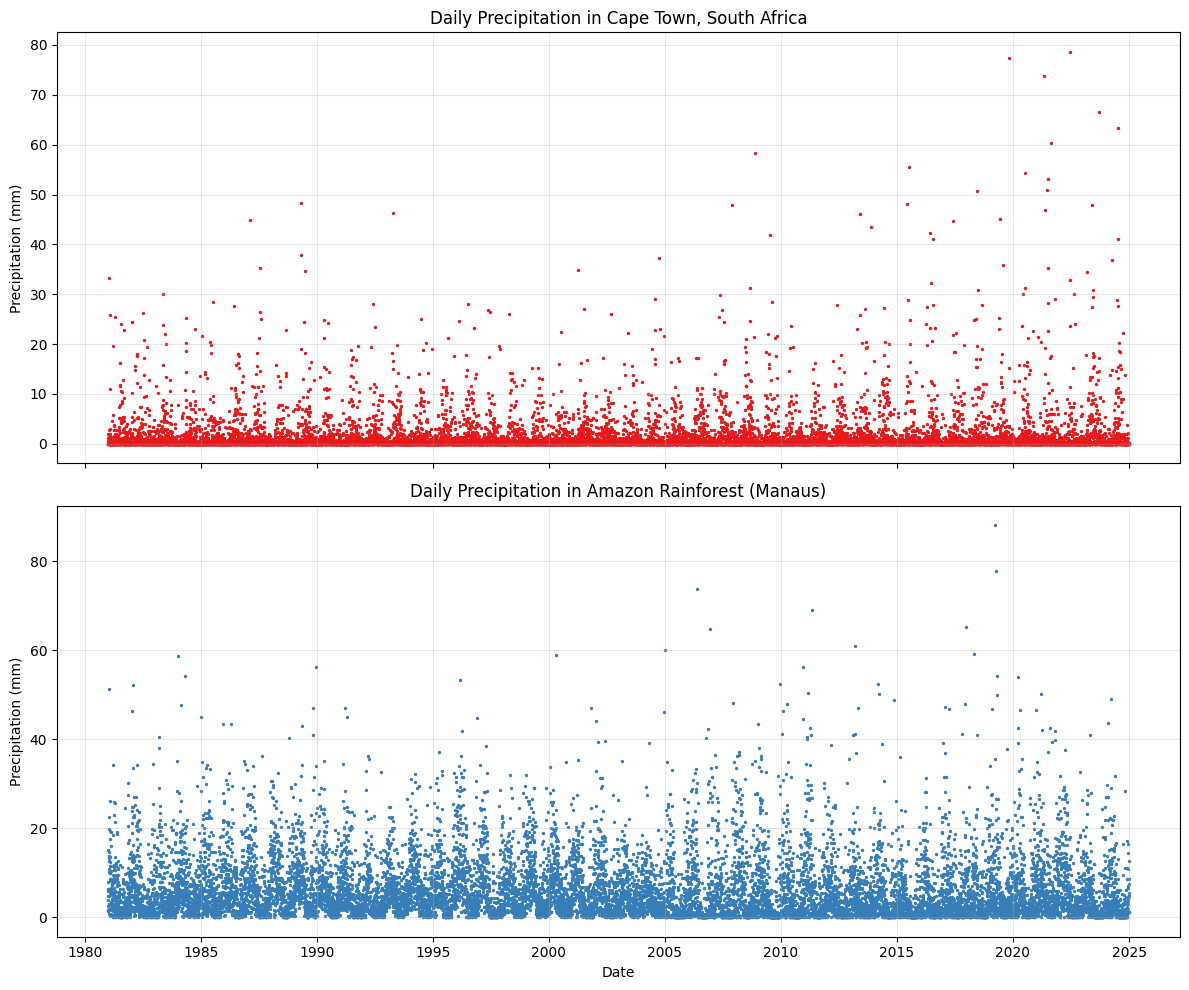

In [ ]:
# Load data
climate_df = pd.read_csv('/content/drive/MyDrive/TDS/Climate/climate_data.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'].astype(str), format='%Y%m%d')

# Filter for the specified cities
selected_cities = [
    'Cape Town, South Africa',
    'Amazon Rainforest (Manaus)',
]
df_selected_cities = climate_df[climate_df['City'].isin(selected_cities)].copy()

# Set up the color palette
colors = sns.color_palette("Set1", len(selected_cities))

# Create vertically stacked subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

for i, city in enumerate(selected_cities):
    df_city = df_selected_cities[df_selected_cities['City'] == city]
    axes[i].scatter(df_city['Date'], df_city['PRECTOTCORR'], s=2, color=colors[i])
    axes[i].set_title(f'Daily Precipitation in {city}')
    axes[i].set_ylabel('Precipitation (mm)')
    axes[i].grid(alpha=0.3)

# Label x-axis only on the bottom subplot
axes[-1].set_xlabel('Date')

plt.tight_layout()
plt.show()

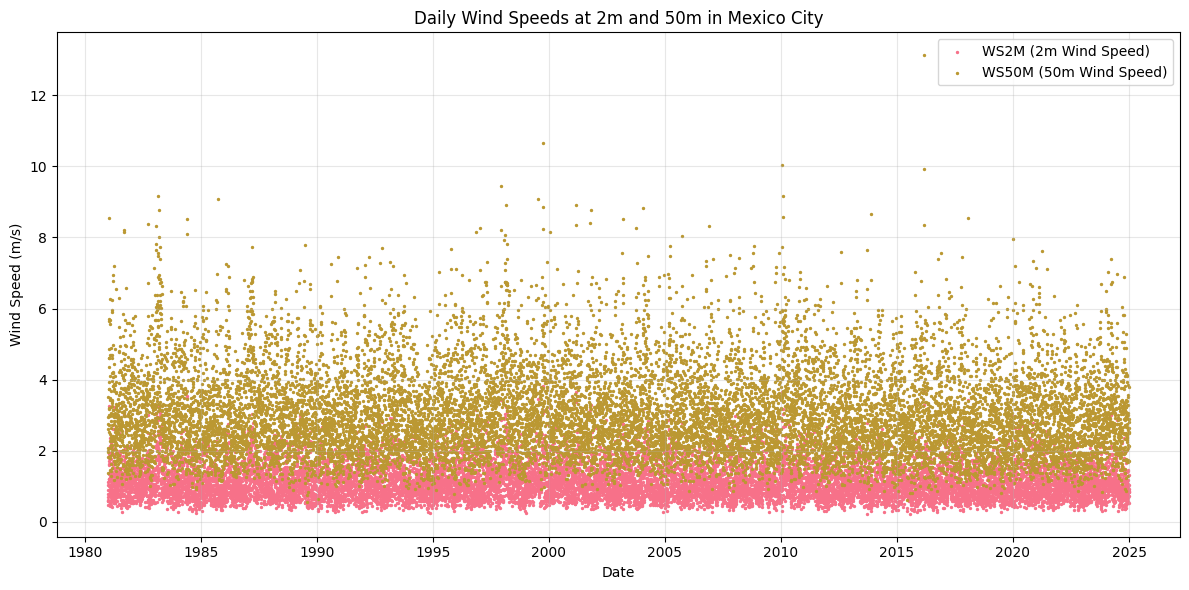

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
climate_df = pd.read_csv('/content/drive/MyDrive/TDS/Climate/climate_data.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'].astype(str), format='%Y%m%d')

# Filter for Mexico City
df_mexico = climate_df[climate_df['City'] == 'Mexico City, Mexico'].copy()

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_palette("husl")

plt.scatter(df_mexico['Date'], df_mexico['WS2M'], s=2, label='WS2M (2m Wind Speed)')
plt.scatter(df_mexico['Date'], df_mexico['WS50M'], s=2, label='WS50M (50m Wind Speed)')

plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Daily Wind Speeds at 2m and 50m in Mexico City')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from scipy import stats      # gives us skewness & kurtosis in one call

# 1) Load data ────────────────────────────────────────────────
climate_df = pd.read_csv('/content/drive/MyDrive/TDS/Climate/climate_data.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'].astype(str), format='%Y%m%d')

# 2) City groups & variable map ───────────────────────────────
precip_cities = ['Cape Town, South Africa', 'Amazon Rainforest (Manaus)']
temp_cities   = ['McMurdo Station, Antarctica', 'Bangkok, Thailand']

targets = [
    ('PRECTOTCORR', precip_cities),
    ('T2M',         temp_cities)
]

def sci_describe(series):
    """Return a Series with count, mean, std, min, quartiles, max, skew, kurt."""
    d = stats.describe(series.dropna(), nan_policy='omit')
    return pd.Series({
        'count': d.nobs,
        'mean':  d.mean,
        'std':   (d.variance)**0.5,
        'min':   d.minmax[0],
        '25%':   series.quantile(0.25),
        '50%':   series.quantile(0.50),
        '75%':   series.quantile(0.75),
        'max':   d.minmax[1],
        'skew':  d.skewness,
        'kurt':  d.kurtosis          # excess (Fisher) kurtosis
    })

# 3) Build one DataFrame per variable, then concatenate ───────
all_tables = []
for col, citylist in targets:
    stats_df = (
        climate_df
        .loc[climate_df['City'].isin(citylist), ['City', col]]
        .groupby('City')[col]
        .apply(sci_describe)
        .unstack(level=0)          # city names become columns
    )
    # add a top-level column label so we can stack them later
    stats_df.columns = pd.MultiIndex.from_product([[col], stats_df.columns])
    all_tables.append(stats_df)

full_stats = pd.concat(all_tables, axis=1)   # one wide table

print(full_stats.round(2))


                     PRECTOTCORR                                       T2M  \
City  Amazon Rainforest (Manaus) Cape Town, South Africa Bangkok, Thailand   
count                   16071.00                16071.00          16071.00   
mean                        5.85                    1.31             27.81   
std                         7.05                    3.91              2.42   
min                         0.00                    0.00             14.26   
25%                         0.97                    0.00             26.69   
50%                         3.50                    0.10             27.77   
75%                         8.16                    0.77             29.14   
max                        88.08                   78.61             36.03   
skew                        2.51                    7.17             -0.42   
kurt                       10.23                   78.34              1.40   

                                   
City  McMurdo Station, Anta

/tmp/ipython-input-8-1390467346.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual = df['T2M'].resample('Y').mean()


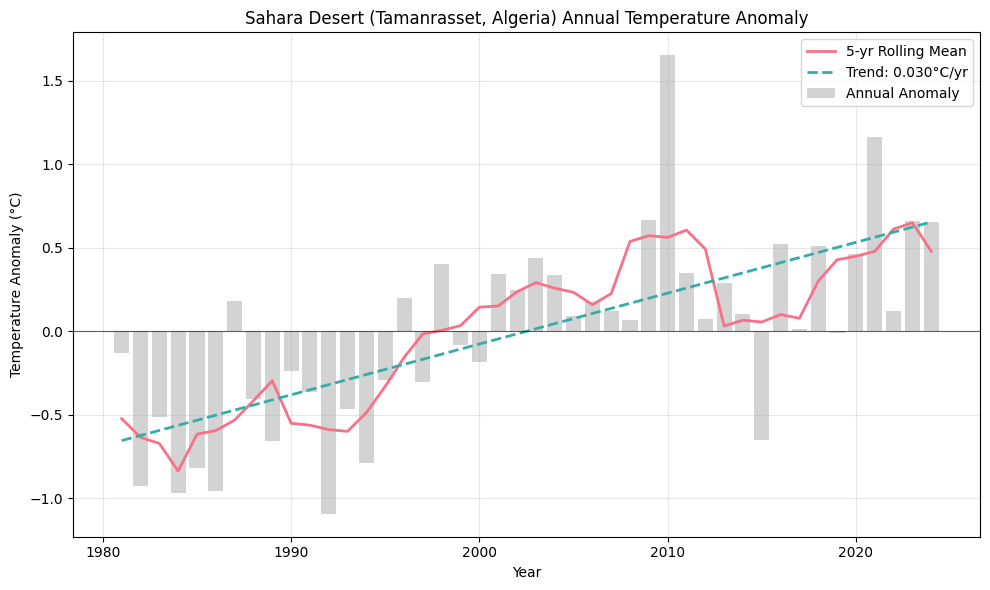

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load combined data
climate_df = pd.read_csv('/content/drive/MyDrive/TDS/Climate/climate_data.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'].astype(str), format='%Y%m%d')

# 2) Filter for Sahara Desert and exclude 2024
city = 'Sahara Desert (Tamanrasset, Algeria)'
df = (
    climate_df
    .loc[climate_df['City'] == city]
    .set_index('Date')
    .sort_index()
)

# 3) Compute annual mean & anomaly
annual = df['T2M'].resample('Y').mean()
baseline = annual.mean()
anomaly = annual - baseline

# 4) 5-year rolling mean
roll5 = anomaly.rolling(window=5, center=True, min_periods=3).mean()

# 5) Linear trend
years = anomaly.index.year
slope, intercept = np.polyfit(years, anomaly.values, 1)
trend = slope * years + intercept

# 6) Plot
plt.figure(figsize=(10, 6))
plt.bar(years, anomaly, color='lightgray', label='Annual Anomaly')
plt.plot(years, roll5, color='C0', linewidth=2, label='5-yr Rolling Mean')
plt.plot(years, trend, color='C3', linestyle='--', linewidth=2,
         label=f'Trend: {slope:.3f}°C/yr')
plt.axhline(0, color='k', linewidth=0.8, alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.title(f'{city} Annual Temperature Anomaly')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load combined data
climate_df = pd.read_csv('/content/drive/MyDrive/TDS/Climate/climate_data.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'].astype(str), format='%Y%m%d')

# 2) Filter for Sahara Desert and exclude 2024
city = 'Sahara Desert (Tamanrasset, Algeria)'
df = (
    climate_df
    .loc[climate_df['City'] == city]
    .set_index('Date')
    .sort_index()
)

# 3) Compute annual mean & anomaly
annual = df['T2M'].resample('Y').mean()
baseline = annual.mean()
anomaly = annual - baseline

# 4) 5-year rolling mean
roll5 = anomaly.rolling(window=5, center=True, min_periods=3).mean()

# 5) Linear trend
years = anomaly.index.year
slope, intercept = np.polyfit(years, anomaly.values, 1)
trend = slope * years + intercept

# 6) Plot
plt.figure(figsize=(10, 6))
plt.bar(years, anomaly, color='lightgray', label='Annual Anomaly')
plt.plot(years, roll5, color='C0', linewidth=2, label='5-yr Rolling Mean')
plt.plot(years, trend, color='C3', linestyle='--', linewidth=2,
         label=f'Trend: {slope:.3f}°C/yr')
plt.axhline(0, color='k', linewidth=0.8, alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.title(f'{city} Annual Temperature Anomaly')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-27-3683786758.py:42: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual   = df_city['T2M'].resample('Y').mean()
/tmp/ipython-input-27-3683786758.py:42: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual   = df_city['T2M'].resample('Y').mean()


Figure saved to Google Drive as 'temperature_anomaly_grid.png'


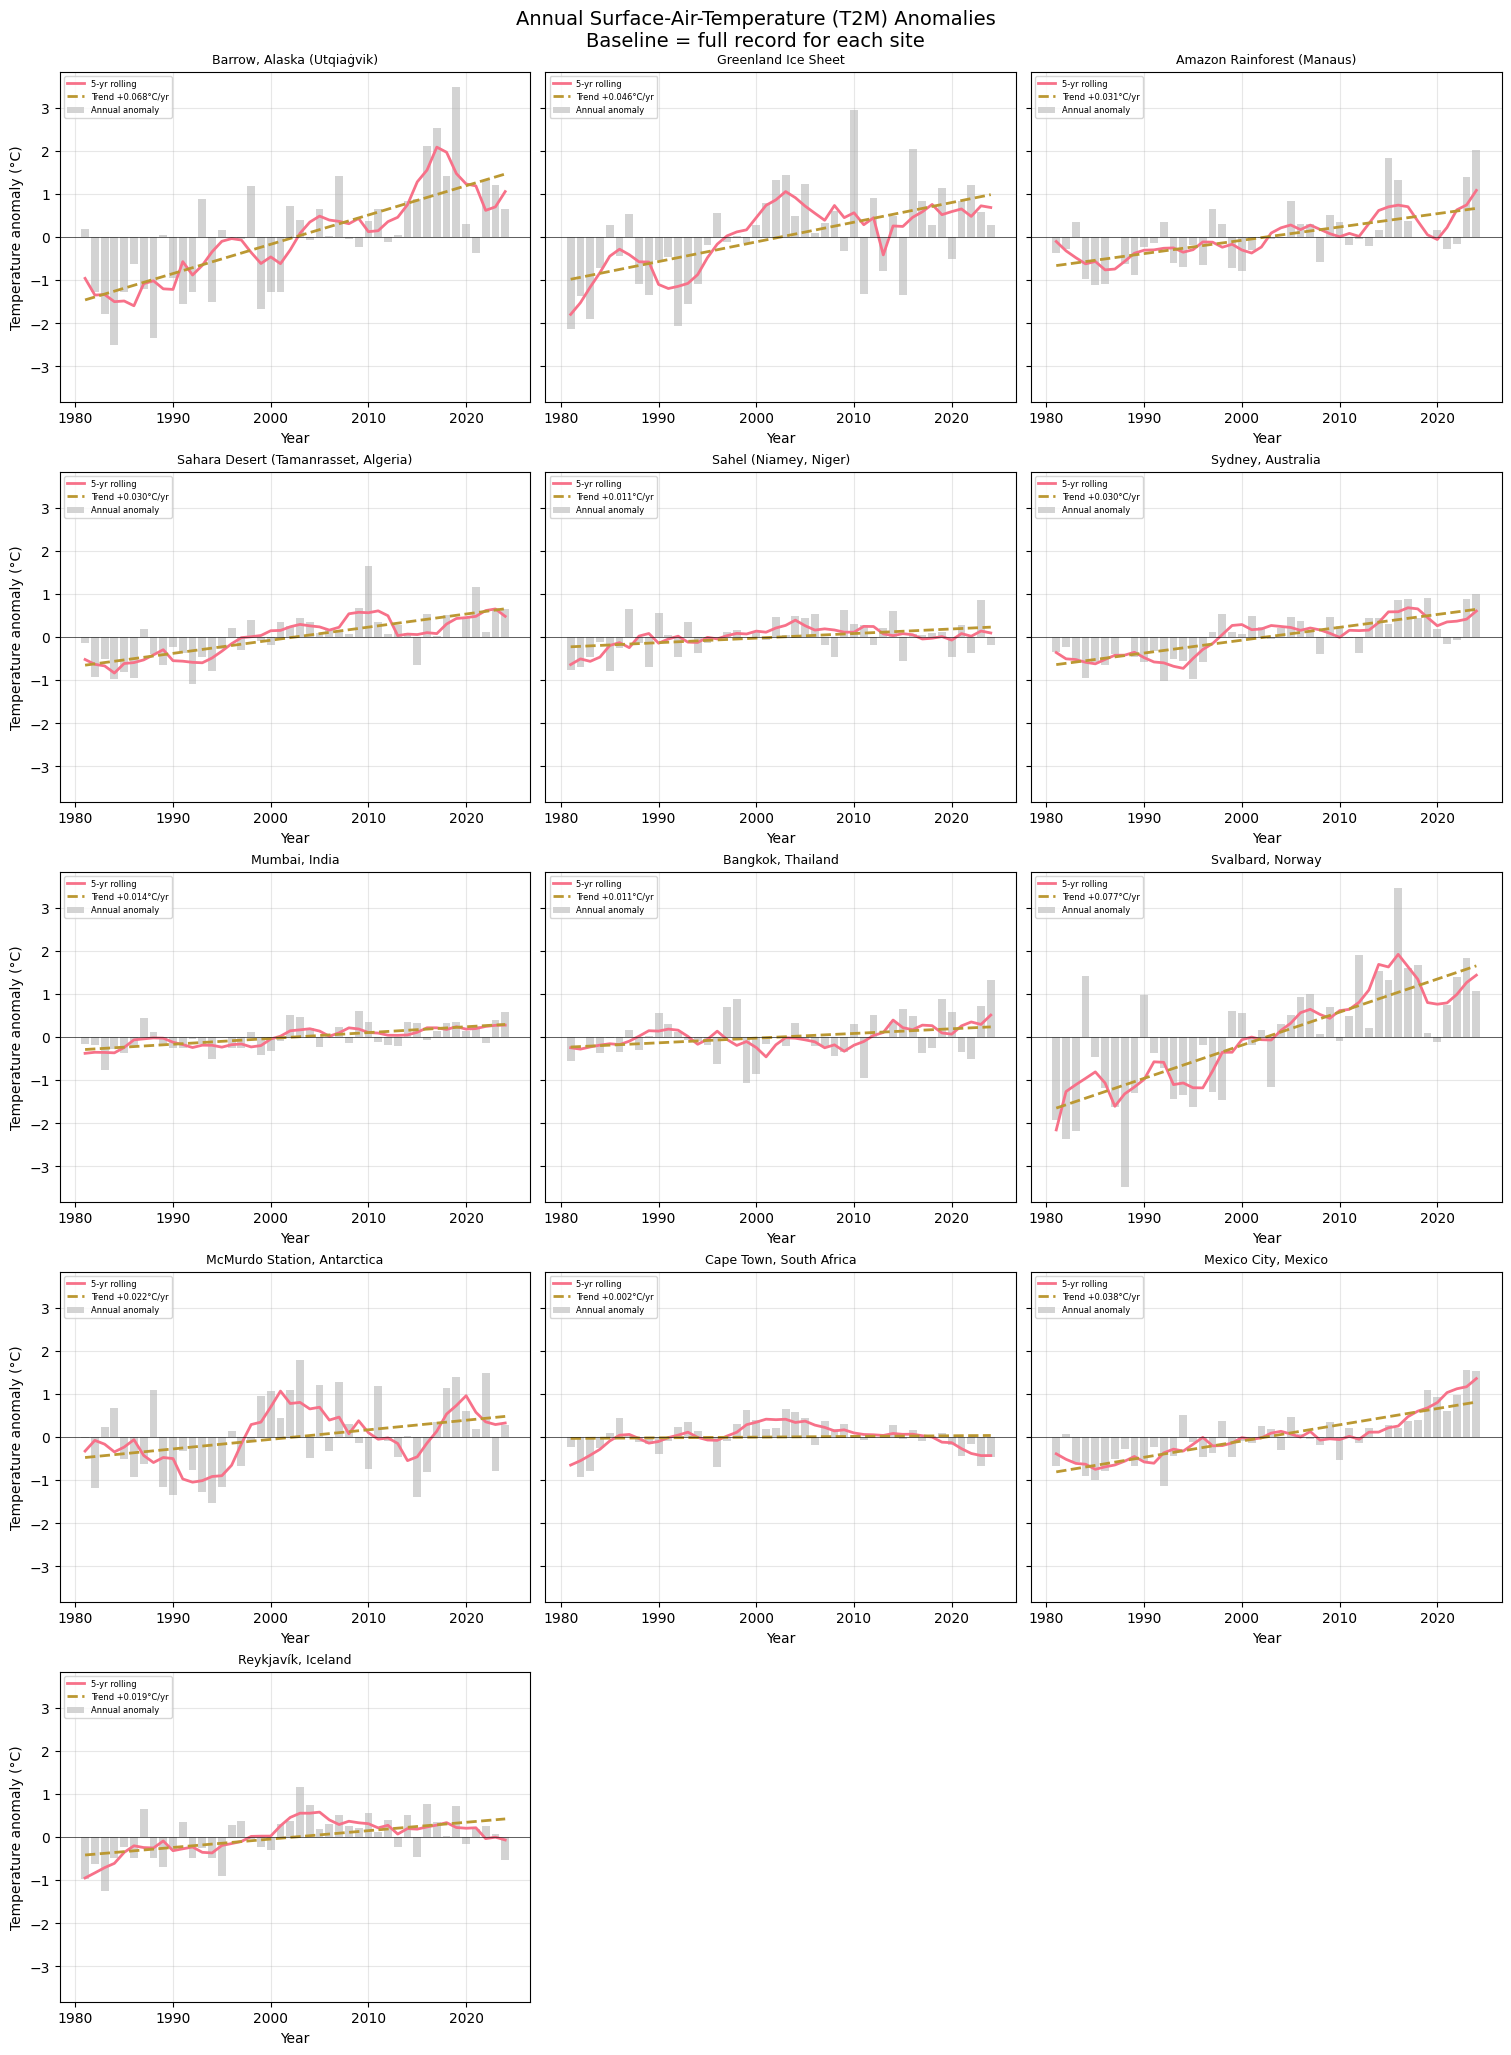

In [ ]:
import math
import matplotlib.pyplot as plt # Make sure matplotlib is imported
import pandas as pd # Make sure pandas is imported
import numpy as np # Make sure numpy is imported


cities = list(interesting_climate_sites.keys())
n_cities = len(cities)

# ---------------------------------------------------------------------------
# 2)  Figure layout (3 columns – change to taste)
# ---------------------------------------------------------------------------
ncols = 3
nrows = math.ceil(n_cities / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5 * ncols, 4 * nrows),   # scales with grid size
    sharey=True,                      # anomalies share a common y-axis
    constrained_layout=True
)
axes = axes.flatten()                 # treat as 1-D array for easy indexing

# ---------------------------------------------------------------------------
# 3)  Per-city loop
# ---------------------------------------------------------------------------
for i, city in enumerate(cities):
    ax = axes[i]

    # -- subset and sanity-check
    df_city = (
        climate_df.loc[climate_df['City'] == city]
                  .set_index('Date')
                  .sort_index()
    )
    if df_city.empty:
        ax.set_visible(False)
        continue

    # -- annual mean, anomaly & 5-yr smooth
    annual   = df_city['T2M'].resample('Y').mean()
    baseline = annual.mean()
    anomaly  = annual - baseline
    roll5    = anomaly.rolling(window=5, center=True, min_periods=3).mean()

    # -- linear trend
    years     = anomaly.index.year
    slope, intercept = np.polyfit(years, anomaly.values, 1)
    trend     = slope * years + intercept

    # -- plot
    ax.bar(years, anomaly, color='lightgray', label='Annual anomaly')
    ax.plot(years, roll5,  linewidth=2, label='5-yr rolling')
    ax.plot(years, trend, linestyle='--', linewidth=2,
            label=f'Trend { slope:+.3f}°C/yr')
    ax.axhline(0, color='k', linewidth=0.7, alpha=0.6)

    # -- cosmetics
    ax.set_title(city, fontsize=9)
    if i % ncols == 0:
        ax.set_ylabel('Temperature anomaly (°C)')
    ax.set_xlabel('Year')
    ax.grid(alpha=0.3)
    ax.legend(fontsize=6, loc='upper left')

# Hide any unused cells in the grid
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Annual Surface-Air-Temperature (T2M) Anomalies\n'
             'Baseline = full record for each site',
             fontsize=14, y=1.02)

# Save the figure before showing it
plt.savefig('/content/drive/MyDrive/temperature_anomaly_grid.png', bbox_inches='tight')
print("Figure saved to Google Drive as 'temperature_anomaly_grid.png'")

plt.show()